题目：

利用水库水位变化预测大坝出水量。

数据集：ex5data1.mat
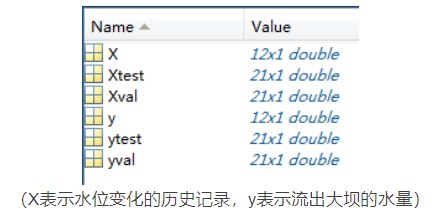

## 1.导入数据

1.导入库、数据集

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.optimize import minimize

data = loadmat('ex5data1.mat')

data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'Xtest', 'ytest', 'Xval', 'yval'])

2.训练集、验证集、测试集

In [3]:
# 训练集
X_train,y_train = data['X'],data['y']
X_train.shape,y_train.shape

((12, 1), (12, 1))

In [4]:
# 验证集
X_val,y_val = data['Xval'],data['yval']
X_val.shape,y_val.shape

((21, 1), (21, 1))

In [5]:
# 测试集
X_test,y_test = data['Xtest'],data['ytest']
X_test.shape,y_test.shape

((21, 1), (21, 1))

In [6]:
# 输入变量插入偏置(引入x0)
X_train = np.insert(X_train,0,1,axis=1)
X_val = np.insert(X_val,0,1,axis=1)
X_test = np.insert(X_test,0,1,axis=1)

3.数据可视化

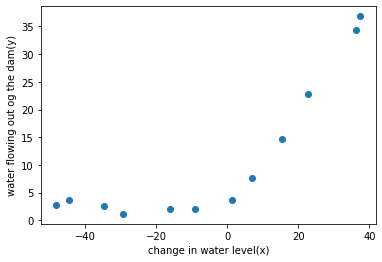

In [7]:
def plot_data():
    fig,ax = plt.subplots()
    ax.scatter(X_train[:,1],y_train)
    ax.set(xlabel = 'change in water level(x)',
          ylabel = 'water flowing out og the dam(y)')
    
plot_data()

## 2. 线性回归

1.代价函数（带正则化）
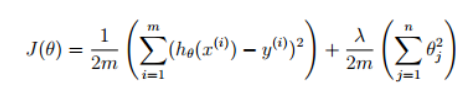

In [8]:
# 定义代价函数
def reg_cost(theta,X,y,lamda):
    
    cost = np.sum(np.power((X@theta-y.flatten()),2))
    reg = theta[1:]@theta[1:] * lamda
    
    return (cost+reg) /(2*len(X))

In [9]:
# 参数初始化
theta = np.ones(X_train.shape[1])
lamda =1
reg_cost(theta,X_train,y_train,lamda)

303.9931922202643

2.梯度函数（带正则化）
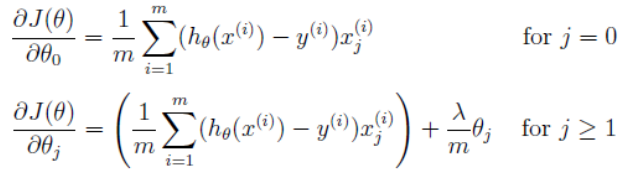

In [10]:
def reg_gradient(theta,X,y,lamda):
    
    grad = (X@theta-y.flatten())@X
    reg = lamda * theta
    reg[0]=0                           # 第一项不参与正则化计算
    
    return (grad+reg) / (len(X))

In [11]:
reg_gradient(theta,X_train,y_train,lamda)

array([-15.30301567, 598.25074417])

3.优化函数 minimize()

In [12]:
def train_model(X,y,lamda):
    
    theta = np.ones(X.shape[1])
    
    # 和之前的minimize（）函数一样
    res  = minimize(fun = reg_cost,
                   x0 = theta,
                   args =(X,y,lamda),
                   method = 'TNC',
                   jac = reg_gradient)
    
    return res.x              # 返回最优参数

In [13]:
theta_final = train_model(X_train,y_train,lamda=0)

4.拟合直线可视化（训练集）

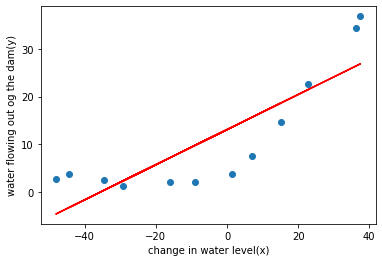

In [14]:
plot_data()
plt.plot(X_train[:,1],X_train@theta_final,c='r')
plt.show()

从图中可以看出，模型欠拟合严重，偏差大。

总结：此时，theta_final已经确定好了，但是发现曲线的拟合程度还远远不够；故：我们画出了学习曲线，发现属于高偏差，所以我们要选择更多的特征来描述曲线，但是，当引入了特征多项式后，过拟合的问题也随之而来，所以紧接着我们要在代价函数后面加入正则化项，并确定lamda。如接下来所示。

5.学习曲线
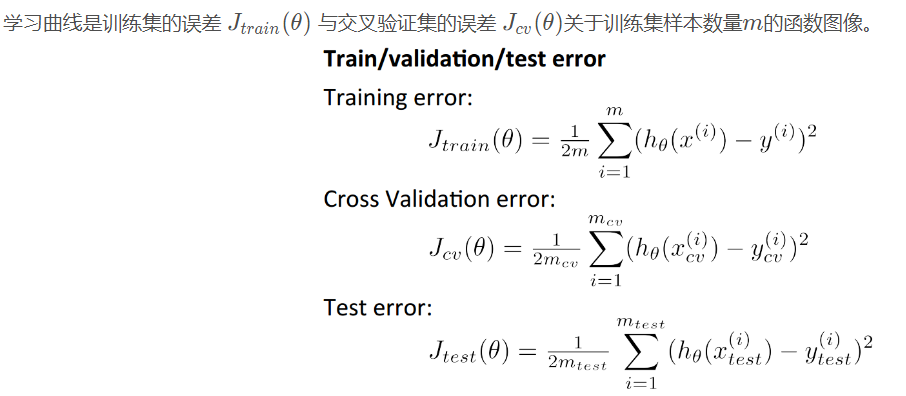

In [15]:
# 定义绘制学习曲线的函数plot_learning_curve
def plot_learning_curve(X_train,y_train,X_val,y_val,lamda):
    
    x = range(1,len(X_train)+1)
    training_cost = []                 # 训练集的误差
    cv_cost = []                       # 验证集的误差
     
    for i in x:
        res = train_model(X_train[:i,:],y_train[:i,:],lamda)
        
        training_cost_i = reg_cost(res,X_train[:i,:],y_train[:i,:],lamda)
        cv_cost_i = reg_cost(res,X_val,y_val,lamda)    # 验证集取自己全部样本
        training_cost.append(training_cost_i)
        cv_cost.append(cv_cost_i)
    
    plt.plot(x,training_cost,label = 'training cost')
    plt.plot(x,cv_cost,label = 'cv cost')
    plt.legend()
    plt.xlabel('number of training examples')
    plt.ylabel('error')
    plt.show()

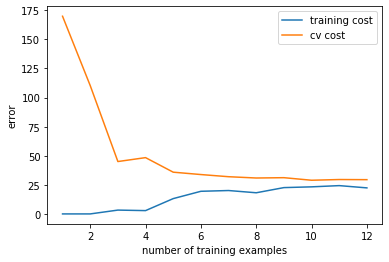

In [16]:
# 需要注意的是，当计算训练集、交叉验证集和测试集误差时，不计算正则项，所以令 λ=0
plot_learning_curve(X_train,y_train,X_val,y_val,lamda=0)

总结：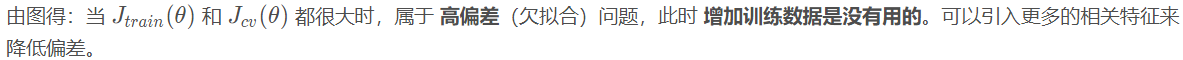

## 3. 多项式回归

1.构造特征多项式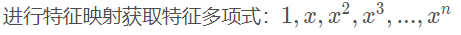

In [19]:
# 定义构成特征多项式
def poly_feature(X,power):
    
    for i in range(2,power+1):
        X = np.insert(X,X.shape[1],np.power(X[:,1],i),axis=1)
    return X

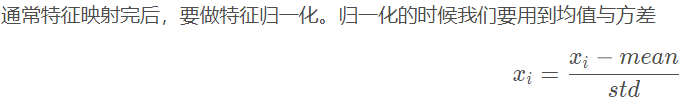

In [18]:
# 定义获得均值与方差
def get_means_stds(X):
    
    means = np.mean(X,axis=0)
    stds = np.std(X,axis=0)
    return means,stds

In [20]:
# 定义特征归一化
def feature_normalize(X,means,stds):
    
    X[:,1:] = ( X[:,1:]  - means[1:]) / stds[1:]
    
    return X

In [21]:
# 获取特征多项式：
power = 6

X_train_poly = poly_feature(X_train,power)       # 获取特征多项式
X_val_poly = poly_feature(X_val,power)
X_test_poly = poly_feature(X_test,power)

train_means,train_stds = get_means_stds(X_train_poly)   # 均值和方差

X_train_norm = feature_normalize(X_train_poly,train_means,train_stds)   # 特征归一化
X_val_norm = feature_normalize(X_val_poly,train_means,train_stds)
X_test_norm = feature_normalize(X_test_poly,train_means,train_stds)

theta_fit = train_model(X_train_norm,y_train,lamda=0)     # 特征归一化

2.拟合曲线可视化（训练集）

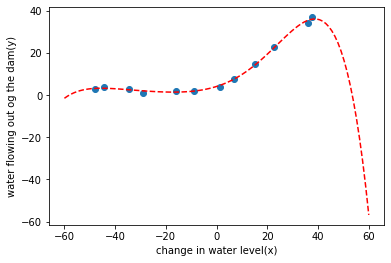

In [22]:
def plot_poly_fit():        # 绘制拟合曲线
    plot_data()             # 绘制原始数据
    
    x = np.linspace(-60,60,100)
    xx = x.reshape(100,1)
    xx = np.insert(xx,0,1,axis=1)
    xx = poly_feature(xx,power)
    xx = feature_normalize(xx,train_means,train_stds)    # 获取横坐标的特征多项式
    
    plt.plot(x, xx@theta_fit,'r--')               # xx @ theta_fit即为曲线的y值
    
plot_poly_fit()

3.学习曲线——改变λ

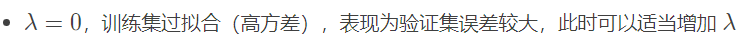

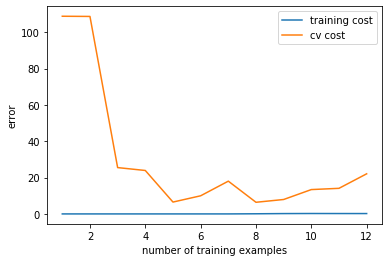

In [23]:
plot_learning_curve(X_train_norm,y_train,X_val_norm,y_val,lamda=0) 

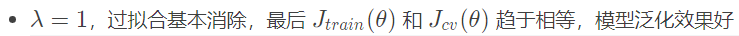

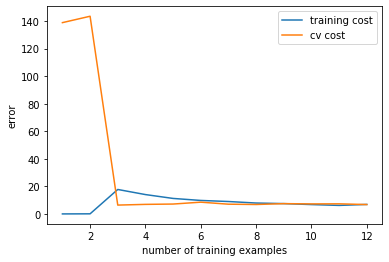

In [24]:
plot_learning_curve(X_train_norm,y_train,X_val_norm,y_val,lamda=1)

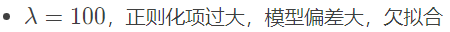

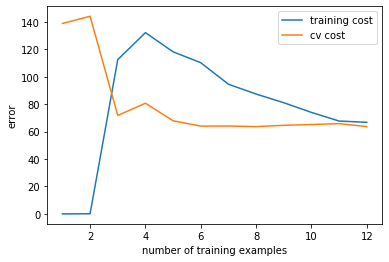

In [25]:
plot_learning_curve(X_train_norm,y_train,X_val_norm,y_val,lamda=100)

4 正则化参数λ的选取

In [26]:
lamdas = [0,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10]      # lamda的候选值

training_cost = []
cv_cost = []

for lamda in lamdas:
    res = train_model(X_train_norm,y_train,lamda)
    
    # 注意：当计算训练集、交叉验证集和测试集误差时，不计算正则项  
    tc = reg_cost(res,X_train_norm,y_train,lamda = 0)
    cv = reg_cost(res,X_val_norm,y_val,lamda=0)
    
    training_cost.append(tc)
    cv_cost.append(cv)

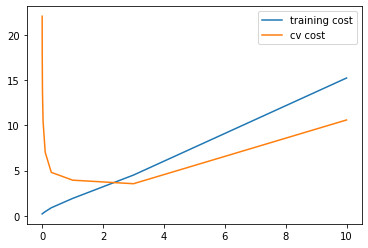

In [27]:
plt.plot(lamdas,training_cost,label='training cost')
plt.plot(lamdas,cv_cost,label='cv cost')
plt.legend()

plt.show()

In [28]:
# 获取cv_cost的最小值
min(cv_cost)

3.540898792857562

In [29]:
# 此时对应的 lamda 值
lamdas[np.argmin(cv_cost)]

3

In [30]:
# 测试集误差
res = train_model(X_train_norm,y_train,lamda =3)
test_cost = reg_cost(res,X_test_norm,y_test,lamda = 0)
print(test_cost)

4.397616166773488


In [34]:
# 将 lamda=3 放在测试集上，绘制出训练集，验证集，测试集的学习曲线
def plot_learning_curve_3(X_train,y_train,X_val,y_val,X_test,y_test,lamda):
    
    x = range(1,len(X_train)+1)
    training_cost = []
    cv_cost = []
    test_cost = []
    
    for i in x:
        res = train_model(X_train[:i,:],y_train[:i,:],lamda)
        training_cost_i = reg_cost(res,X_train[:i,:],y_train[:i,:],lamda = 0)
        cv_cost_i = reg_cost(res,X_val,y_val,lamda = 0)
        test_cost_i = reg_cost(res,X_test,y_test,lamda = 0)
        
        training_cost.append(training_cost_i)
        cv_cost.append(cv_cost_i)
        test_cost.append(test_cost_i)
    
    plt.plot(x,training_cost,label = 'training cost')    
    plt.plot(x,cv_cost,label = 'cv cost')   
    plt.plot(x,test_cost,label = 'test cost')
    plt.legend()
    plt.xlabel('number of training examples')
    plt.ylabel('error')
    plt.show()

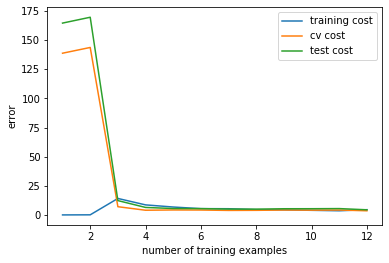

In [35]:
plot_learning_curve_3(X_train_norm, y_train,X_val_norm, y_val,X_test_norm, y_test,lamda=3)

## 总结：至此，我们确定了1、theta_final  2、更多的特征来描述数据 3、合适的lamda(这里lamda=3)